In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import TimeDistributed
import seaborn as sns



In [16]:
csv_file = 'wikiart_csv/Style_train.csv'  #  'Artist_train.csv', 'Genre_train.csv' 
data = pd.read_csv(csv_file, header=None)
data.columns = ['image_path', 'class_index']

# load head
print(data.head())


                                          image_path  class_index
0  Impressionism/edgar-degas_landscape-on-the-orn...           12
1         Realism/camille-corot_mantes-cathedral.jpg           21
2  Abstract_Expressionism/gene-davis_untitled-197...            0
3      Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg           24
4  Impressionism/maurice-prendergast_paris-boulev...           12


In [17]:
# 数据路径
data_dir = 'wikiart'  # 数据目录
img_size = (128,128)  # 调整图像大小以适应模型
batch_size = 32

# Data enhancement of training data
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # 归一化 normalization
    rotation_range=30,  # 随机旋转
    width_shift_range=0.2,  # 水平平移
    height_shift_range=0.2,  # 垂直平移
    shear_range=0.2,  # 随机错切变换
    zoom_range=0.2,  # 随机缩放
    validation_split=0.2,  # 80% 训练，20% 验证
    horizontal_flip=True  # 随机水平翻转
)

# 使用 flow_from_directory 加载数据
# 训练集
train_gen = datagen.flow_from_directory(
    data_dir,  # 数据集路径
    target_size=img_size,  # 图像调整大小
    batch_size=batch_size,  # 批量大小
    class_mode='categorical',  # 类别模式，返回 one-hot 编码的标签
    subset='training'
)

# 验证集
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# 类别数量
num_classes = train_gen.num_classes

Found 80 images belonging to 10 classes.
Found 19 images belonging to 10 classes.


In [18]:
# Check value for image pixel 
# Notice that they already within 0-255
image_batch_original, labels_batch_original = next(iter(train_gen))
first_image = image_batch_original[0]

print("The shape for original image batch is", image_batch_original.shape,
     "\nThis means that there are",image_batch_original.shape[0],"images in a training batch,",
      "with size of",image_batch_original.shape[1],"by",image_batch_original.shape[2] )

print("\nUse the 1st image inside the training batch as an example.",
      "\nThe shape for original label batch is", labels_batch_original.shape,
       "\nThe minimum value for original pixel is", np.min(first_image),
       "\nThe maximum value for original pixel is", np.max(first_image),
       "\nThe mean value for original pixel is", np.mean(first_image),
       "\nThe standard derivative value for original pixel is", np.std(first_image))

The shape for original image batch is (32, 128, 128, 3) 
This means that there are 32 images in a training batch, with size of 128 by 128

Use the 1st image inside the training batch as an example. 
The shape for original label batch is (32, 10) 
The minimum value for original pixel is 0.0 
The maximum value for original pixel is 0.85097873 
The mean value for original pixel is 0.28052643 
The standard derivative value for original pixel is 0.22985004


### ConvLSTM
- 卷积部分 (Conv2D): 提取图像的空间特征。
- LSTM 部分: 图像的局部特征序列

In [19]:
# 自定义生成器，扩展时间步维度
def add_time_step_dimension(generator):
    for images, labels in generator:
        # 增加时间步维度: (batch_size, 128, 128, 3) -> (batch_size, 1, 128, 128, 3)
        images = np.expand_dims(images, axis=1)
        yield images, labels

train_gen = add_time_step_dimension(train_gen)
val_gen = add_time_step_dimension(val_gen)

# 创建 ConvLSTM 模型
model = Sequential()

# ConvLSTM2D 层
model.add(ConvLSTM2D(filters=32, 
                    kernel_size=(3, 3), 
                    activation='relu',
                    input_shape=(None, 
                                img_size[0], 
                                img_size[1], 
                                3),  # 时间步设为 None
                    return_sequences=False
                    )
        )  # 改成 False
model.add(BatchNormalization())

# Conv2D 层
model.add(Conv2D(filters=64, 
                kernel_size=(3, 3), 
                activation='relu', 
                padding='same'))
# 1st Convolutional layer: 16 filters, each filter sized 3x3
# The activaction function is 'relu'
model.add(Conv2D(16, kernel_size= (3, 3), activation='relu')),
# 2nd Convolutional layer: 16 filters, each filter sized 3x3
# The activaction function is 'relu'
model.add(Conv2D(16, kernel_size= (3, 3), activation='relu')),
# Max Pooling layer, sized 2x2  
model.add(MaxPooling2D(pool_size = (2, 2))), 
# 3rd Convolutional layer: 24 filters, each filter sized 3x3
# The activaction function is 'relu'
model.add(Conv2D(24, kernel_size= (3, 3), activation='relu')),
# 4th Convolutional layer: 24 filters, each filter sized 3x3
# The activaction function is 'relu'
model.add(Conv2D(24, kernel_size= (3, 3), activation='relu')), 
        
# MaxPolling 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 展平层
model.add(Flatten())

# 全连接层
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# 输出层
model.add(Dense(num_classes, activation='softmax'))

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 126, 126, 32)   │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 124, 16)   │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 122, 122, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 59, 59, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 57, 57, 24)     │         5,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,408,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489,178 (9.50 MB)

 Trainable params: 2,489,114 (9.50 MB)

 Non-trainable params: 64 (256.00 B)

In [20]:
# # 定义卷积-递归网络模型
# model = models.Sequential([
#     # 卷积层提取空间特征
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
    
#     # 添加 LSTM 层以捕获时序信息
#     layers.Reshape((-1, 128)),  # 将特征展开成一个时间步序列，大小为 (batch_size, time_steps, features)
#     layers.LSTM(64, activation='relu'),  # LSTM 层处理时间步信息
    
#     # 全连接层
#     layers.Dense(128, activation='relu'),
#     layers.Dense(len(train_gen.class_indices), activation='softmax')  # 输出层：根据类别数设定
# ])
# 编译模型
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # 查看模型架构
# model.summary()

In [21]:
# 训练模型
history = model.fit(
    train_gen,
    epochs=1,
    validation_data=val_gen,
)


   2833/Unknown 1950s 688ms/step - accuracy: 0.6537 - loss: 0.9632

In [ ]:
# 评估模型
test_loss, test_accuracy = model.evaluate(train_gen)
print(f'测试损失: {test_loss}, 测试准确率: {test_accuracy}')

2546/2546 ━━━━━━━━━━━━━━━━━━━━ 639s 251ms/step - accuracy: 0.3426 - loss: 2.0630
测试损失: 2.062014102935791, 测试准确率: 0.33950936794281006


In [ ]:
# 获取预测结果
y_pred = model.predict(train_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

2546/2546 ━━━━━━━━━━━━━━━━━━━━ 635s 249ms/step


In [ ]:
# 绘制准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.summary()

In [ ]:
# 获取验证集标签和预测结果
val_gen.reset()
predictions = model.predict(val_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes

# 分类报告
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))


In [ ]:
# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=list(val_gen.class_indices.keys()), columns=list(val_gen.class_indices.keys()))


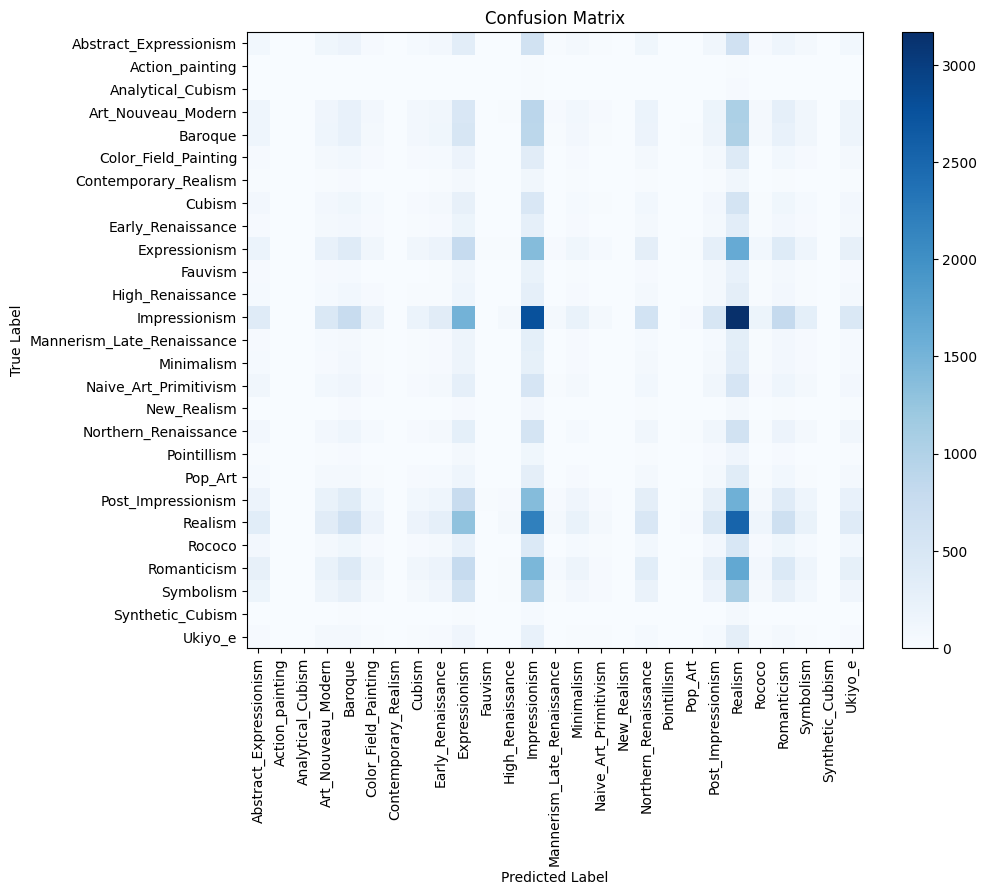

In [ ]:
# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
# 分类报告
print(classification_report(train_gen.classes, y_pred_classes, target_names=list(train_gen.class_indices.keys())))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.03      0.03      0.03      2782
           Action_painting       0.00      0.00      0.00        98
         Analytical_Cubism       0.00      0.00      0.00       110
        Art_Nouveau_Modern       0.05      0.03      0.04      4334
                   Baroque       0.05      0.06      0.05      4240
      Color_Field_Painting       0.03      0.02      0.02      1615
      Contemporary_Realism       0.00      0.00      0.00       481
                    Cubism       0.03      0.02      0.02      2235
         Early_Renaissance       0.01      0.02      0.02      1391
             Expressionism       0.08      0.12      0.10      6736
                   Fauvism       0.01      0.00      0.00       934
          High_Renaissance       0.02      0.00      0.01      1343
             Impressionism       0.16      0.21      0.18     13060
Mannerism_Late_Renaissance       0.01      0.00

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
# # 保存模型
# model.save('WikiArt_CNN_LSTM.h5')

# # 加载模型
# from tensorflow.keras.models import load_model
# model = load_model('WikiArt_CNN_LSTM.h5')


   9/2546 ━━━━━━━━━━━━━━━━━━━━ 11:18 267ms/step

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 492/2546 ━━━━━━━━━━━━━━━━━━━━ 8:49 258ms/step

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 631s 248ms/step


KeyError: 0

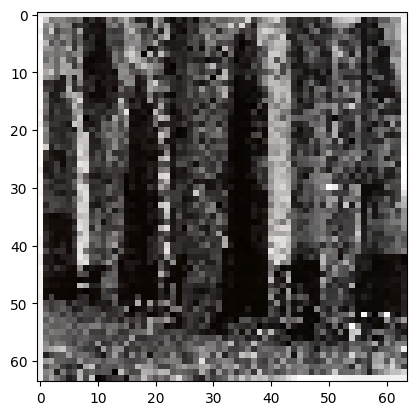

In [ ]:
# # 预测并找到错误分类的样本
# y_pred = model.predict(train_gen)
# y_pred_classes = np.argmax(y_pred, axis=1)  # 获取预测的类别
# y_true = train_gen.classes  # 获取真实的类别标签

# # 查找错误分类的样本
# incorrect_idx = np.where(y_pred_classes != y_true)[0]

# # 查看前 5 个错误分类的图像
# for idx in incorrect_idx[:5]:  # 查看前 5 个错误分类的图像
#     img_path = os.path.join(train_dir, train_gen.filenames[idx])
#     img = load_img(img_path, target_size=image_size)
#     plt.imshow(img)
#     true_label = train_gen.class_indices[train_gen.classes[idx]]  # 获取真实标签
#     predicted_label = train_gen.class_indices[y_pred_classes[idx]]  # 获取预测标签
#     plt.title(f"True Label: {true_label}, Predicted: {predicted_label}")
#     plt.show()


In [ ]:
# # 数据增强配置
# datagen = ImageDataGenerator(
#     rescale=1./255,  # 归一化
#     rotation_range=30,  # 随机旋转
#     width_shift_range=0.2,  # 水平平移
#     height_shift_range=0.2,  # 垂直平移
#     shear_range=0.2,  # 随机错切变换
#     zoom_range=0.2,  # 随机缩放
#     horizontal_flip=True  # 随机水平翻转
# )

# # 假设 `X` 和 `y` 是你的图像数据和标签
# # 使用增强的数据进行训练
# train_generator = datagen.flow(X, y, batch_size=batch_size)

# # 训练模型
# history = model.fit(
#     train_generator,
#     epochs=10,
#     validation_split=0.2  # 进行 20% 的验证集划分
# )